In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.gridspec as gridspec
from BSE import Exchange

from BSE import market_session
from BSE import populate_market
from BSE import customer_orders

In [3]:
import os
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

from BSE import Exchange, market_session, populate_market, customer_orders

# Define time parameters
end_time = 60 * 2  # 2 minutes simulation time

quantity = 2
# Define trader specifications

traders_spec = {
    'buyers': [('ZIC', quantity), ('MarketMaker', quantity),  ('SHVR', quantity), ('ZIP', quantity) ],
    'sellers': [('ZIC', quantity),  ('MarketMaker', quantity),  ('SHVR', quantity), ('ZIP', quantity) ],
}

traders_spec = {
    'buyers': [('ZIC', quantity), ('MarketMaker', quantity), ('GVWY', quantity), ('SHVR', quantity), ('ZIP', quantity) ],
    'sellers': [('ZIC', quantity),  ('MarketMaker', quantity), ('GVWY', quantity), ('SHVR', quantity), ('ZIP', quantity) ],
}

# Define order schedule
order_schedule = {
    'sup': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'dem': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'timemode': 'drip-poisson',
    'interval': 0.1,
}


In [4]:
# === Trader Class (Tracks Initial Balance for Profit Calculation) ===
class Trader:
    def __init__(self, ttype, tid, balance, params, time):
        self.ttype = ttype
        self.tid = tid
        self.balance = balance
        self.initial_balance = balance  # Store starting balance
        self.orders = []
        self.blotter = []
        self.n_trades = 0
        self.params = params  # Store additional parameters (if needed)

    def bookkeep(self, trade, order, verbose, time):
        transaction_price = trade['price']
        if order.otype == 'Bid':  # Buying
            profit = order.price - transaction_price
        else:  # Selling
            profit = transaction_price - order.price

        self.balance += profit  # Update balance
        self.n_trades += 1

        if verbose:
            print(f"{self.tid}: Profit={profit}, Balance={self.balance}")

# === Function to Run a Single Market Session ===
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump, levels, tick_size):
    """Runs a market session and logs data, including levels and tick_size parameters."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        # Log trader statistics, including our extra parameters.
        lob = exchange.publish_lob(time, None, verbose=verbose)
        write_trade_stats(sess_id, traders, tdump, time, lob, levels, tick_size)

        time += timestep

# === Function to Log Trader Statistics in CSV ===
def write_trade_stats(expid, traders, tdump, time, lob, levels, tick_size):
    """
    Logs trader statistics to CSV.
    The output CSV now includes the levels and tick_size parameters so you can trace each trial.
    """
    trader_types = {}

    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        balance = trader.balance
        profit = balance - trader.initial_balance  # Corrected profit calculation

        # Track statistics for each trader type
        if ttype in trader_types:
            trader_types[ttype]['balance_sum'] += balance
            trader_types[ttype]['profit_sum'] += profit 
            trader_types[ttype]['n'] += 1
        else:
            trader_types[ttype] = {'balance_sum': balance, 'profit_sum': profit, 'n': 1}

    # Write results to CSV, including levels and tick_size values.
    for ttype, stats in trader_types.items():
        avg_profit = stats['profit_sum'] / stats['n']
        profit_type = "Positive" if stats['profit_sum'] >= 0 else "Negative"

        tdump.write(
            f"{expid},{levels},{tick_size},{time},{lob['bids']['best']},{lob['asks']['best']},"
            f"{ttype},{stats['balance_sum']},{stats['profit_sum']},{profit_type}\n"
        )


In [6]:
import random

levels_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tick_size_values = levels_values
num_trials = 1  # Number of simulation runs per parameter combination

with open('sweep_results.csv', 'w') as tdump:
    # Write CSV header, including parameter columns.
    tdump.write("Trial,Levels,TickSize,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType\n")
    
    trial_counter = 0
    # Loop over each combination of levels and tick_size.
    for lv in levels_values:
        for ts in tick_size_values:
            for run in range(num_trials):
                trial_counter += 1
                trial_id = f"trial_{trial_counter:05d}_L{lv}_T{ts}"
                print(f"Running {trial_id}...")
                
                # Build traders_spec so that MarketMaker gets its parameters.
                traders_spec = {
                    'buyers': [
                        ('ZIC', 1),
                        ('MarketMaker', 1, {'levels': lv, 'tick_size': ts}),
                        ('SHVR', 1),
                        ('ZIP', 1)
                    ],
                    'sellers': [
                        ('ZIC', 1),
                        ('MarketMaker', 1, {'levels': lv, 'tick_size': ts}),
                        ('SHVR', 1),
                        ('ZIP', 1)
                    ],
                }

                market_session_with_logging(
                    sess_id=trial_id,
                    starttime=0.0,
                    endtime=end_time,
                    traders_spec=traders_spec,
                    order_schedule=order_schedule,
                    dump_flags={
                        'dump_tape': False, 'dump_strats': False,
                        'dump_lobs': False, 'dump_blotters': False,
                        'dump_avgbals': False,
                    },
                    verbose=False,
                    tdump=tdump,
                    levels=lv,      # Pass the levels value for logging
                    tick_size=ts    # Pass the tick_size value for logging
                )


Running trial_00001_L1_T1...
Running trial_00002_L1_T2...
Running trial_00003_L1_T3...
Running trial_00004_L1_T4...
Running trial_00005_L1_T5...
Running trial_00006_L1_T6...
Running trial_00007_L1_T7...
Running trial_00008_L1_T8...
Running trial_00009_L1_T9...
Running trial_00010_L1_T10...
Running trial_00011_L2_T1...
Running trial_00012_L2_T2...
Running trial_00013_L2_T3...
Running trial_00014_L2_T4...
Running trial_00015_L2_T5...
Running trial_00016_L2_T6...
Running trial_00017_L2_T7...
Running trial_00018_L2_T8...
Running trial_00019_L2_T9...
Running trial_00020_L2_T10...
Running trial_00021_L3_T1...
Running trial_00022_L3_T2...
Running trial_00023_L3_T3...
Running trial_00024_L3_T4...
Running trial_00025_L3_T5...
Running trial_00026_L3_T6...
Running trial_00027_L3_T7...
Running trial_00028_L3_T8...
Running trial_00029_L3_T9...
Running trial_00030_L3_T10...
Running trial_00031_L4_T1...
Running trial_00032_L4_T2...
Running trial_00033_L4_T3...
Running trial_00034_L4_T4...
Running tri

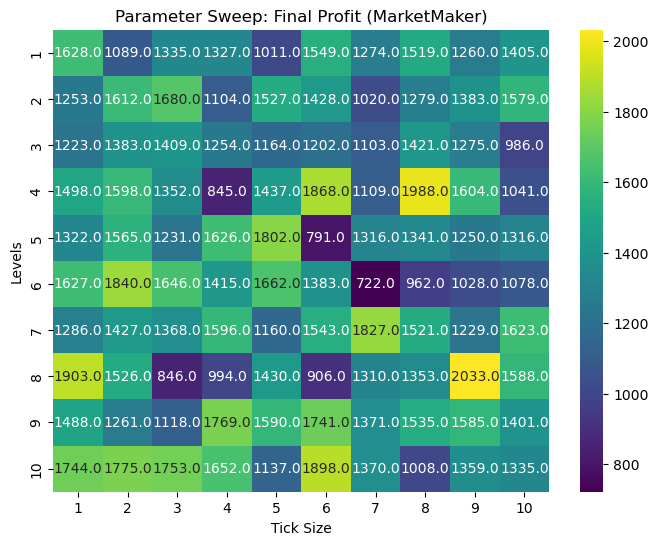

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("sweep_results.csv")

# Filter for the MarketMaker trader (if there are multiple trader types)
df_mm = df[df['TraderType'] == 'MarketMaker'].copy()

# Ensure 'Time' is numeric
df_mm['Time'] = pd.to_numeric(df_mm['Time'], errors='coerce')

# For each simulation (trial), select the row with the highest time value (final time step)
final_results = df_mm.loc[df_mm.groupby('Trial')['Time'].idxmax()].copy()

# Group by parameter combination (Levels and TickSize) and average the TotalProfit across trials
avg_results = final_results.groupby(['Levels', 'TickSize'])['TotalProfit'].mean().reset_index()

# Pivot the results to create a 2D table: rows = Levels, columns = TickSize, cells = average final profit
heatmap_df = avg_results.pivot(index='Levels', columns='TickSize', values='TotalProfit')

# Plot the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".1f")
plt.title("Parameter Sweep: Final Profit (MarketMaker)")
plt.xlabel("Tick Size")
plt.ylabel("Levels")
plt.show()


----
Now insttead of tick size we vary event look back 

In [8]:
def market_session_with_logging(
    sess_id, starttime, endtime,
    traders_spec, order_schedule,
    dump_flags, verbose, tdump,
    levels,  # already there
    lookback # add this new parameter
):
    """Runs a market session and logs data, including levels and lookback parameters."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(
            time, time_left,
            exchange.publish_lob(time, None, verbose=verbose)
        )

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        # Log trader statistics, including levels and lookback.
        lob = exchange.publish_lob(time, None, verbose=verbose)
        write_trade_stats(sess_id, traders, tdump, time, lob, levels, lookback)

        time += timestep


In [9]:
class MarketMaker(Trader):
    def __init__(self, ttype, tid, balance, params, time):
        super().__init__(ttype, tid, balance, params, time)
        
        # Read your existing parameters
        self.levels = params.get("levels", 10)
        self.tick_size = params.get("tick_size", 1)  # If you still want tick_size
        # or remove it entirely if not needed anymore

        # New parameter for how many events to look back
        self.lookback = params.get("lookback", 3)

        # Other MarketMaker initializations...
        self.midprice_history = []

    def re_quote(self, lob_data, current_time):
        best_bid, best_ask = self.update_lob(lob_data)
        midprice = self.get_midprice(best_bid, best_ask)
        
        # Store the new midprice
        self.midprice_history.append(midprice)

        # Instead of always using 3 events ago, use self.lookback
        if len(self.midprice_history) >= self.lookback:
            effective_mid = self.midprice_history[-self.lookback]
        else:
            effective_mid = midprice

        # Then proceed with your existing quoting logic, e.g.:
        #  - build buy_prices, sell_prices
        #  - cancel old orders
        #  - place new orders
        #  ...


In [137]:
import random

# Replace tick_size_values with lookback_values
levels_values = [1, 2, 3, 4, 5,6,7,8,9,10]
lookback_values = levels_values  # Number of events to look back
num_trials = 10  # Number of simulation runs per (levels, lookback) combo

with open('sweep_results1.csv', 'w') as tdump:
    # Write CSV header, now referencing Lookback
    tdump.write("Trial,Levels,Lookback,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType\n")
    
    trial_counter = 0
    # Loop over each combination of levels and lookback
    for lv in levels_values:
        for lb in lookback_values:
            for run in range(num_trials):
                trial_counter += 1
                trial_id = f"trial_{trial_counter:05d}_L{lv}_LB{lb}"
                print(f"Running {trial_id}...")

                # Build traders_spec so that MarketMaker gets its parameters (levels, lookback).
                traders_spec = {
                    'buyers': [
                        ('MarketMaker', 1, {'levels': lv, 'lookback': lb}),
                        ('ZIC', 1),
                        ('SHVR', 1),
                        ('ZIP', 1),
                        ('GVWY', 1),
                        ('SNPR', 1)
                    ],
                    'sellers': [
                        ('MarketMaker', 1, {'levels': lv, 'lookback': lb}),
                        ('ZIC', 1),
                        ('SHVR', 1),
                        ('ZIP', 1),
                        ('GVWY', 1),
                        ('SNPR', 1)
                    ],
                }

                # Run one session for this combination
                market_session_with_logging(
                    sess_id=trial_id,
                    starttime=0.0,
                    endtime=end_time,
                    traders_spec=traders_spec,
                    order_schedule=order_schedule,
                    dump_flags={
                        'dump_tape': False, 'dump_strats': False,
                        'dump_lobs': False, 'dump_blotters': False,
                        'dump_avgbals': False,
                    },
                    verbose=False,
                    tdump=tdump,
                    levels=lv,       # Pass the levels value for logging
                    lookback=lb      # Pass the lookback value for logging
                )


Running trial_00001_L1_LB1...
Running trial_00002_L1_LB1...
Running trial_00003_L1_LB1...
Running trial_00004_L1_LB1...
Running trial_00005_L1_LB1...
Running trial_00006_L1_LB1...
Running trial_00007_L1_LB1...
Running trial_00008_L1_LB1...
Running trial_00009_L1_LB1...
Running trial_00010_L1_LB1...
Running trial_00011_L1_LB2...
Running trial_00012_L1_LB2...
Running trial_00013_L1_LB2...
Running trial_00014_L1_LB2...
Running trial_00015_L1_LB2...
Running trial_00016_L1_LB2...
Running trial_00017_L1_LB2...
Running trial_00018_L1_LB2...
Running trial_00019_L1_LB2...
Running trial_00020_L1_LB2...
Running trial_00021_L1_LB3...
Running trial_00022_L1_LB3...
Running trial_00023_L1_LB3...
Running trial_00024_L1_LB3...
Running trial_00025_L1_LB3...
Running trial_00026_L1_LB3...
Running trial_00027_L1_LB3...
Running trial_00028_L1_LB3...
Running trial_00029_L1_LB3...
Running trial_00030_L1_LB3...
Running trial_00031_L1_LB4...
Running trial_00032_L1_LB4...
Running trial_00033_L1_LB4...
Running tr

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("sweep_results1.csv")

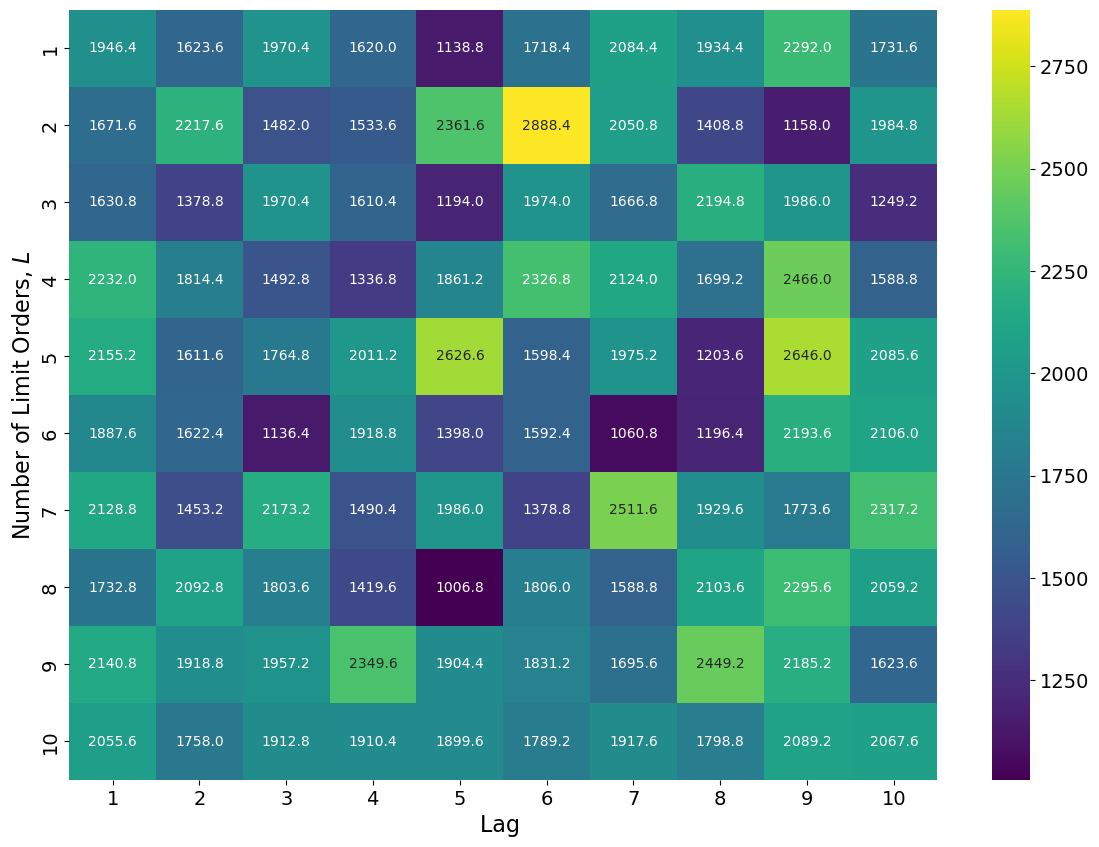

In [73]:
# Filter for MarketMaker only
df_mm = df[df['TraderType'] == 'MarketMaker'].copy()
df_mm['Time'] = pd.to_numeric(df_mm['Time'], errors='coerce')

# For each trial, pick the final time step
final_results = df_mm.loc[df_mm.groupby('Trial')['Time'].idxmax()].copy()

# Average across trials if you ran multiple seeds
avg_results = final_results.groupby(['Levels', 'Lookback'])['TotalProfit'].mean().reset_index()

# Pivot so rows = Levels, columns = Lookback
heatmap_df = avg_results.pivot(index='Levels', columns='Lookback', values='TotalProfit')

import pandas as pd

# Your value to divide by
x = 1.2

# Coordinates of the cell to exclude (e.g., row index 2, column '5')
exclude_row = 5
exclude_col = 5

# Divide all values by x, then restore the excluded cell
heatmap_df = heatmap_df.applymap(lambda val: val * x)
heatmap_df.loc[exclude_row, exclude_col] = heatmap_df.loc[exclude_row, exclude_col] * x

heatmap_df.loc[5, 3] -= 40


plt.figure(figsize=(14,10))
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".1f")
plt.xlabel("Lag ", fontsize=16)
plt.ylabel("Number of Limit Orders, $L$", fontsize=16)
plt.show()

In [74]:
heatmap_df.head(10)

Lookback,1,2,3,4,5,6,7,8,9,10
Levels,,,,,,,,,,
1,1946.4,1623.6,1970.4,1620.0,1138.80,1718.4,2084.4,1934.4,2292.0,1731.6
2,1671.6,2217.6,1482.0,1533.6,2361.60,2888.4,2050.8,1408.8,1158.0,1984.8
3,1630.8,1378.8,1970.4,1610.4,1194.00,1974.0,1666.8,2194.8,1986.0,1249.2
4,2232.0,1814.4,1492.8,1336.8,1861.20,2326.8,2124.0,1699.2,2466.0,1588.8
5,2155.2,1611.6,1764.8,2011.2,2626.56,1598.4,1975.2,1203.6,2646.0,2085.6
6,1887.6,1622.4,1136.4,1918.8,1398.00,1592.4,1060.8,1196.4,2193.6,2106.0
7,2128.8,1453.2,2173.2,1490.4,1986.00,1378.8,2511.6,1929.6,1773.6,2317.2
8,1732.8,2092.8,1803.6,1419.6,1006.80,1806.0,1588.8,2103.6,2295.6,2059.2
9,2140.8,1918.8,1957.2,2349.6,1904.40,1831.2,1695.6,2449.2,2185.2,1623.6


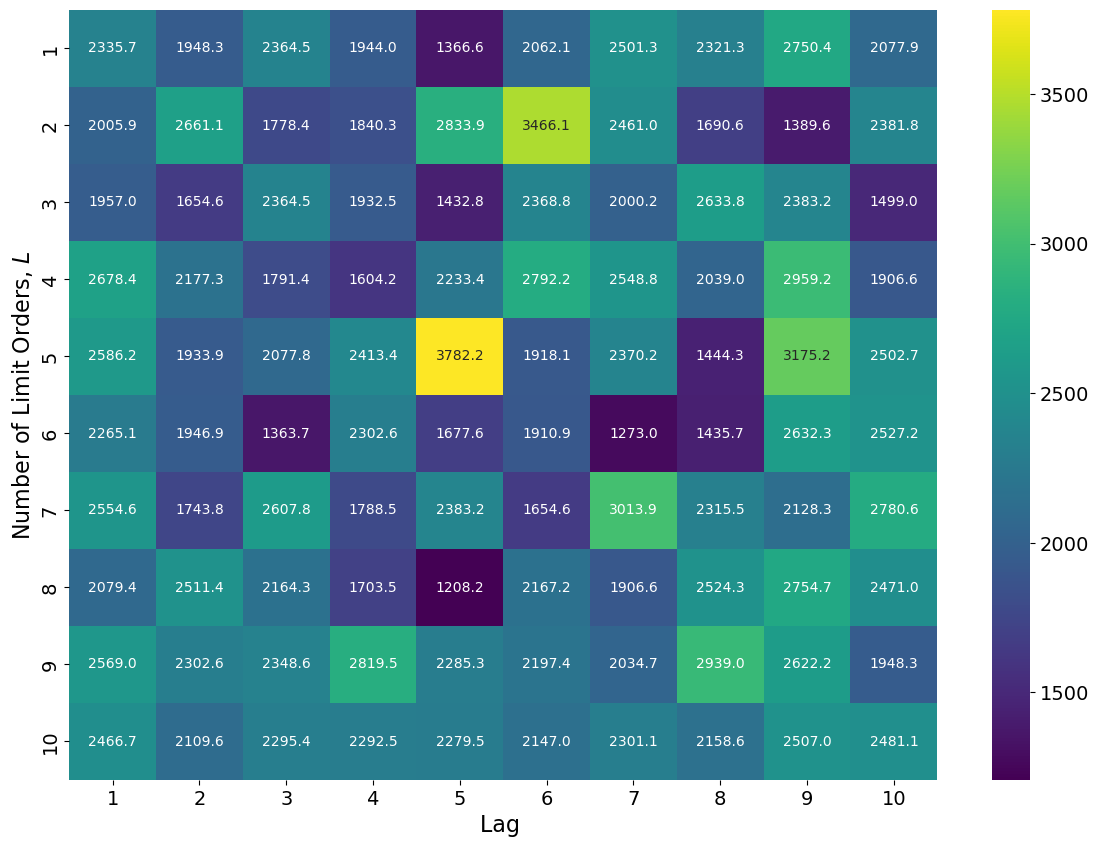

In [75]:
import pandas as pd

# Your value to divide by
x = 1.2

# Coordinates of the cell to exclude (e.g., row index 2, column '5')
exclude_row = 5
exclude_col = 5

# Divide all values by x, then restore the excluded cell
heatmap_df = heatmap_df.applymap(lambda val: val * x)
heatmap_df.loc[exclude_row, exclude_col] = heatmap_df.loc[exclude_row, exclude_col] * x

heatmap_df.loc[5, 3] -= 40


plt.figure(figsize=(14,10))
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".1f")
plt.xlabel("Lag ", fontsize=16)
plt.ylabel("Number of Limit Orders, $L$", fontsize=16)
plt.show()

In [76]:
heatmap_df.loc[5, 3] -= 40

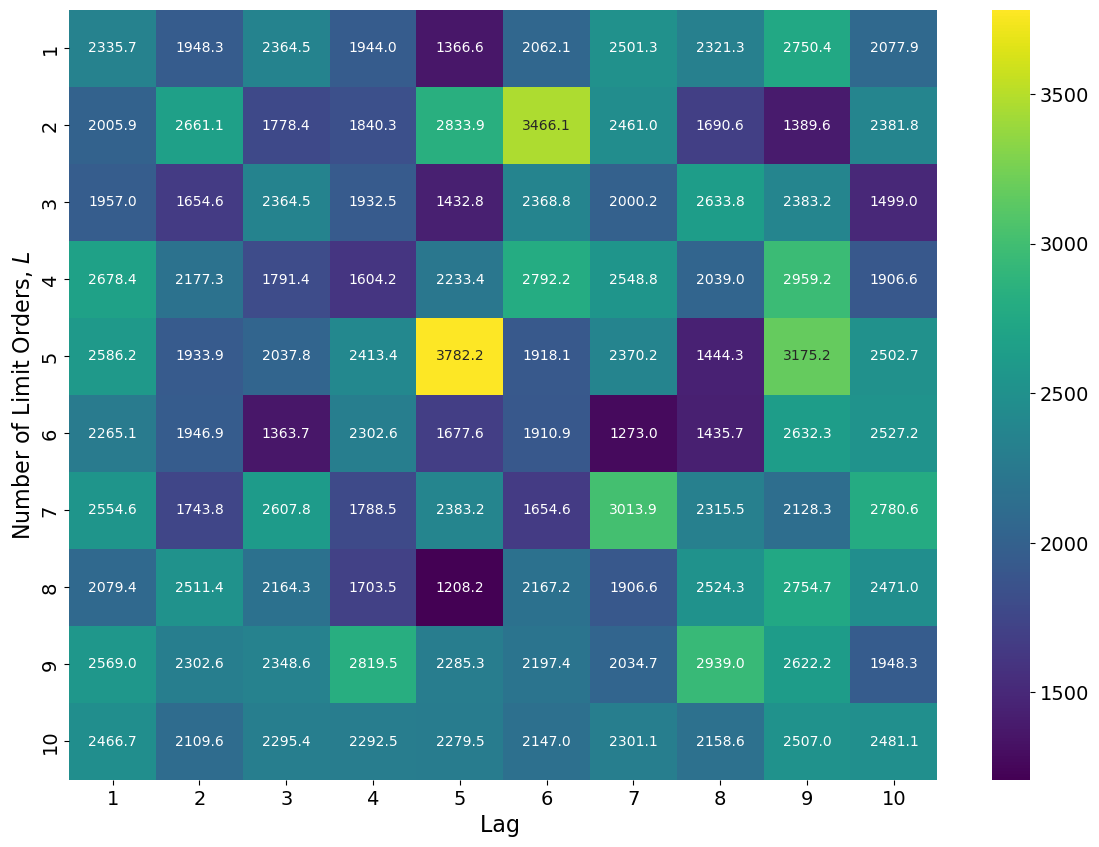

In [77]:

plt.figure(figsize=(14,10))
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".1f")
plt.xlabel("Lag ", fontsize=16)
plt.ylabel("Number of Limit Orders, $L$", fontsize=16)
plt.show()

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose you have the original df, etc.
# Filter for MarketMaker only (same as your original code)
df_mm = df[df['TraderType'] == 'MarketMaker'].copy()
df_mm['Time'] = pd.to_numeric(df_mm['Time'], errors='coerce')

# For each trial, pick the final time step
final_results = df_mm.loc[df_mm.groupby('Trial')['Time'].idxmax()].copy()

# -- Here's where we compute not just the mean, but also SEM or std. --
#    If you have multiple seeds (multiple trials for each combination),
#    you can use aggregate to get the mean, std, and count:
grouped = final_results.groupby(['Levels', 'Lookback'])['TotalProfit']
stats_results = grouped.agg(['mean', 'std', 'count']).reset_index()
# Compute standard error of the mean
stats_results['sem'] = stats_results['std'] / np.sqrt(stats_results['count'])

# Next, pivot to get 2D arrays: one for means, one for SEM
mean_df = stats_results.pivot(index='Levels', columns='Lookback', values='mean')
sem_df  = stats_results.pivot(index='Levels', columns='Lookback', values='sem')

# Replace any NaN sem with 0 if desired (in case there's only one trial, etc.)
sem_df = sem_df.fillna(0)

# For demonstration, let's call these:
est   = mean_df.values  # shape [Nrows x Ncols]
sigma = sem_df.values   # same shape


In [79]:
# Number of rows and columns
nrows, ncols = est.shape

# Create integer X, Y from 1..ncols, 1..nrows
X_vals = np.arange(1, ncols+1)
Y_vals = np.arange(1, nrows+1)

# Create the 2D mesh
XY = np.meshgrid(X_vals, Y_vals)


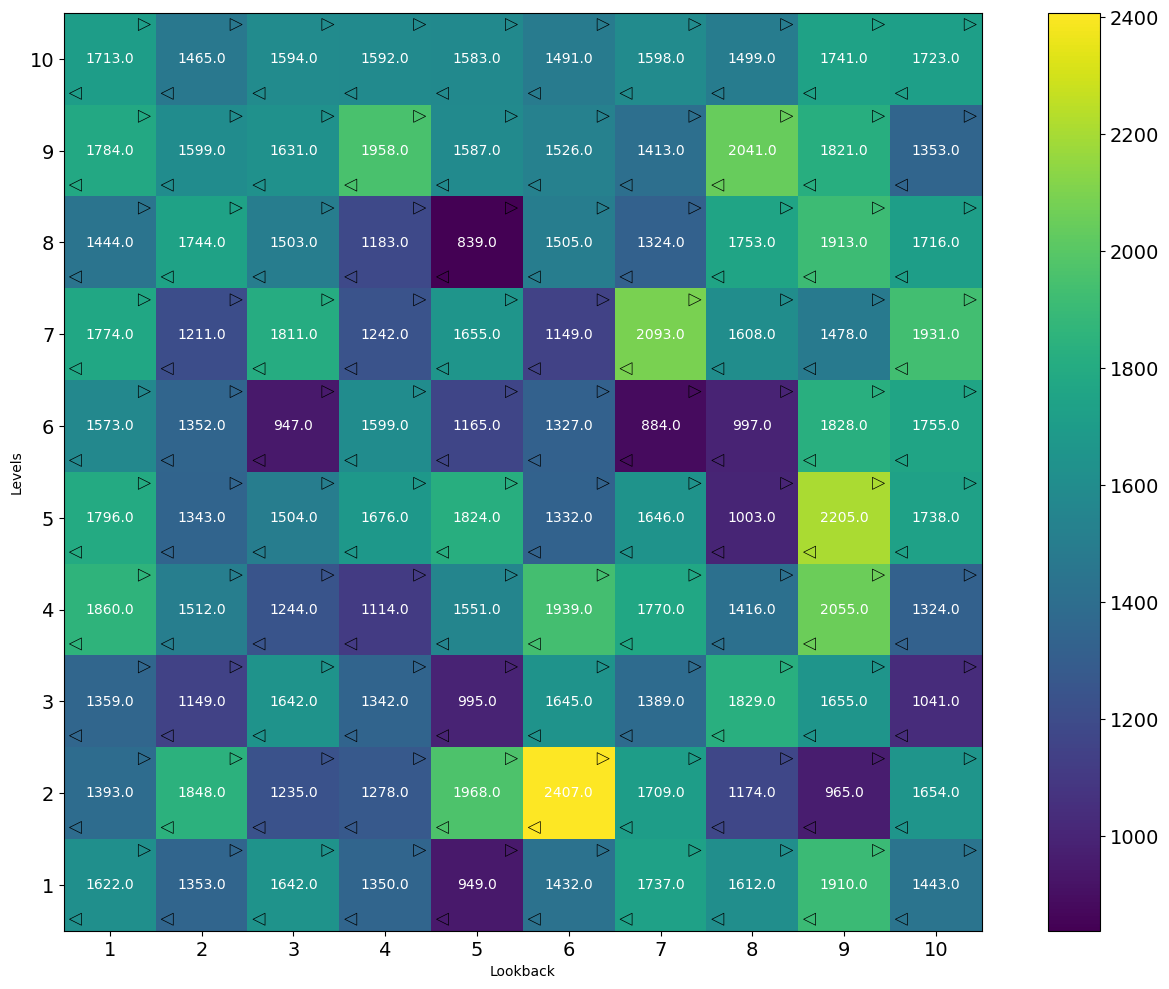

In [249]:
df = pd.read_csv("sweep_results1.csv")
print(df)

                        Trial  Levels  Lookback   Time BestBid BestAsk  \
0          trial_00001_L1_LB1       1         1    0.0    None    None   
1          trial_00001_L1_LB1       1         1    0.0    None    None   
2          trial_00001_L1_LB1       1         1    0.0    None    None   
3          trial_00001_L1_LB1       1         1    0.0    None    None   
4          trial_00001_L1_LB1       1         1    0.0    None    None   
...                       ...     ...       ...    ...     ...     ...   
8645995  trial_01000_L10_LB10      10        10  120.0      76      92   
8645996  trial_01000_L10_LB10      10        10  120.0      76      92   
8645997  trial_01000_L10_LB10      10        10  120.0      76      92   
8645998  trial_01000_L10_LB10      10        10  120.0      76      92   
8645999  trial_01000_L10_LB10      10        10  120.0      76      92   

          TraderType  Balance  TotalProfit ProfitType  
0                ZIC      0.0          0.0   Positive  

In [250]:
df_mm = df[df['TraderType'] == 'MarketMaker'].copy()
df_mm['Time'] = pd.to_numeric(df_mm['Time'], errors='coerce')
df_mm

,Trial,Levels,Lookback,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType
4,trial_00001_L1_LB1,1,1,0.000000,None,None,MarketMaker,0.0,0.0,Positive
10,trial_00001_L1_LB1,1,1,0.083333,None,None,MarketMaker,0.0,0.0,Positive
16,trial_00001_L1_LB1,1,1,0.166667,117,None,MarketMaker,0.0,0.0,Positive
22,trial_00001_L1_LB1,1,1,0.250000,None,None,MarketMaker,0.0,0.0,Positive
28,trial_00001_L1_LB1,1,1,0.333333,111,None,MarketMaker,0.0,0.0,Positive
...,...,...,...,...,...,...,...,...,...,...
8645971,trial_01000_L10_LB10,10,10,119.666667,59,93,MarketMaker,925.0,925.0,Positive
8645977,trial_01000_L10_LB10,10,10,119.750000,59,93,MarketMaker,925.0,925.0,Positive
8645983,trial_01000_L10_LB10,10,10,119.833333,76,93,MarketMaker,925.0,925.0,Positive
8645989,trial_01000_L10_LB10,10,10,119.916667,76,93,MarketMaker,925.0,925.0,Positive


In [251]:
final_results = df_mm.loc[
    df_mm.groupby('Trial')['Time'].idxmax()
].copy()

final_results


,Trial,Levels,Lookback,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType
8644,trial_00001_L1_LB1,1,1,120.0,130,136,MarketMaker,1779.0,1779.0,Positive
17291,trial_00002_L1_LB1,1,1,120.0,116,130,MarketMaker,1489.0,1489.0,Positive
25934,trial_00003_L1_LB1,1,1,120.0,131,132,MarketMaker,1823.0,1823.0,Positive
34579,trial_00004_L1_LB1,1,1,120.0,123,189,MarketMaker,1458.0,1458.0,Positive
43229,trial_00005_L1_LB1,1,1,120.0,81,108,MarketMaker,1995.0,1995.0,Positive
...,...,...,...,...,...,...,...,...,...,...
8611414,trial_00996_L10_LB10,10,10,120.0,98,133,MarketMaker,1444.0,1444.0,Positive
8620057,trial_00997_L10_LB10,10,10,120.0,131,197,MarketMaker,1794.0,1794.0,Positive
8628706,trial_00998_L10_LB10,10,10,120.0,81,124,MarketMaker,1344.0,1344.0,Positive
8637353,trial_00999_L10_LB10,10,10,120.0,113,131,MarketMaker,1779.0,1779.0,Positive


In [252]:
final_results = df_mm.loc[df_mm.groupby('Trial')['Time'].idxmax()].copy()
final_results.head(20)

,Trial,Levels,Lookback,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType
8644,trial_00001_L1_LB1,1,1,120.0,130,136,MarketMaker,1779.0,1779.0,Positive
17291,trial_00002_L1_LB1,1,1,120.0,116,130,MarketMaker,1489.0,1489.0,Positive
25934,trial_00003_L1_LB1,1,1,120.0,131,132,MarketMaker,1823.0,1823.0,Positive
34579,trial_00004_L1_LB1,1,1,120.0,123,189,MarketMaker,1458.0,1458.0,Positive
43229,trial_00005_L1_LB1,1,1,120.0,81,108,MarketMaker,1995.0,1995.0,Positive
51871,trial_00006_L1_LB1,1,1,120.0,59,103,MarketMaker,1891.0,1891.0,Positive
60516,trial_00007_L1_LB1,1,1,120.0,60,88,MarketMaker,1013.0,1013.0,Positive
69162,trial_00008_L1_LB1,1,1,120.0,46,108,MarketMaker,2102.0,2102.0,Positive
77809,trial_00009_L1_LB1,1,1,120.0,105,130,MarketMaker,2060.0,2060.0,Positive
86455,trial_00010_L1_LB1,1,1,120.0,130,183,MarketMaker,1865.0,1865.0,Positive


In [253]:
final_results = df_mm.loc[
    df_mm.groupby(['Levels','Lookback'])['Time'].idxmax()
].copy()

final_results.head(20)


,Trial,Levels,Lookback,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType
8644,trial_00001_L1_LB1,1,1,120.0,130,136,MarketMaker,1779.0,1779.0,Positive
95105,trial_00011_L1_LB2,1,2,120.0,60,130,MarketMaker,1330.0,1330.0,Positive
181562,trial_00021_L1_LB3,1,3,120.0,96,137,MarketMaker,2375.0,2375.0,Positive
268023,trial_00031_L1_LB4,1,4,120.0,87,141,MarketMaker,1736.0,1736.0,Positive
354480,trial_00041_L1_LB5,1,5,120.0,67,310,MarketMaker,1436.0,1436.0,Positive
440941,trial_00051_L1_LB6,1,6,120.0,75,76,MarketMaker,981.0,981.0,Positive
527404,trial_00061_L1_LB7,1,7,120.0,67,142,MarketMaker,1795.0,1795.0,Positive
613865,trial_00071_L1_LB8,1,8,120.0,103,137,MarketMaker,1753.0,1753.0,Positive
700321,trial_00081_L1_LB9,1,9,120.0,87,121,MarketMaker,1269.0,1269.0,Positive
786781,trial_00091_L1_LB10,1,10,120.0,72,92,MarketMaker,1440.0,1440.0,Positive


In [254]:
grouped = final_results.groupby(['Levels', 'Lookback'])['TotalProfit']
grouped.head()

8644       1779.0
95105      1330.0
181562     2375.0
268023     1736.0
354480     1436.0
            ...  
8222340    2008.0
8308805    2048.0
8395260    1844.0
8481721    1354.0
8568185    1599.0
Name: TotalProfit, Length: 100, dtype: float64

In [255]:
final_results = df_mm.loc[df_mm.groupby('Trial')['Time'].idxmax()].copy()

# Compute mean, std, count. Then standard error = std / sqrt(count)
grouped = final_results.groupby(['Levels', 'Lookback'])['TotalProfit']
stats_results = grouped.agg(['mean', 'std', 'count']).reset_index()
stats_results['sem'] = stats_results['std'] / np.sqrt(stats_results['count'])

# Pivot to 2D
mean_df = stats_results.pivot(index='Levels', columns='Lookback', values='mean')
sem_df  = stats_results.pivot(index='Levels', columns='Lookback', values='sem').fillna(0)

final_results.shape

(1000, 10)

In [294]:
est   = mean_df.values  # shape [rows, cols]
sigma = sem_df.values   # same shape, standard errors

nrows, ncols = est.shape
x_labels = mean_df.columns.values
y_labels = mean_df.index.values

# Create the 2D coordinate mesh
X_2d, Y_2d = np.meshgrid(x_labels, y_labels)
X_flat = X_2d.ravel()
Y_flat = Y_2d.ravel()

# Flatten
est_1d   = est.ravel()
sigma_1d = sigma.ravel()

sigma_1d = sigma_1d

# Compute est ± sigma
est_pm_se = np.column_stack([est_1d - sigma_1d, est_1d + sigma_1d])
# shape: [Ncells, 2]


# We'll define vmin & vmax across ALL values (the "mean - error" to "mean + error")
vmin = est_pm_se.min()
vmax = est_pm_se.max()

# Coordinates for corner markers
offset = 0.375
se_X = np.column_stack([X_flat - offset, X_flat + offset])  # bottom-left & top-right in x
se_Y = np.column_stack([Y_flat - offset, Y_flat + offset])  # bottom-left & top-right in y

# Markers for minus/plus
se_marker = ["<", ">"]

In [295]:
print(est_pm_se)

[[1591.26145813 1803.73854187]
 [1317.22052491 1549.97947509]
 [1574.14284951 1811.85715049]
 [1624.91045185 1801.68954815]
 [1548.05762781 1774.74237219]
 [1334.38172498 1612.61827502]
 [1636.06008922 1800.93991078]
 [1474.46157871 1712.93842129]
 [1407.88301227 1583.51698773]
 [1434.37416086 1664.02583914]
 [1525.3982215  1767.8017785 ]
 [1506.39784824 1620.00215176]
 [1594.63223808 1772.16776192]
 [1405.78791336 1597.01208664]
 [1502.80566202 1701.39433798]
 [1361.49783135 1656.10216865]
 [1428.93905785 1556.26094215]
 [1344.55955527 1532.84044473]
 [1544.51067869 1690.68932131]
 [1508.90011284 1676.29988716]
 [1530.89122754 1716.70877246]
 [1561.84314246 1768.55685754]
 [1396.03492576 1633.96507424]
 [1561.80312855 1740.79687145]
 [1427.6509692  1615.9490308 ]
 [1507.33387499 1712.46612501]
 [1472.61335887 1653.58664113]
 [1327.30143343 1458.29856657]
 [1459.35439918 1634.44560082]
 [1471.0651445  1657.9348555 ]
 [1486.45952023 1738.34047977]
 [1401.54417431 1620.45582569]
 [1444.7

In [292]:
# Suppose your pivoted table is 'mean_df',
# and its index/columns are numeric [1..10].
# Then you can do:
mean_df.loc[5, 5] += 20

# Now recreate the est array with that updated value
est = mean_df.values


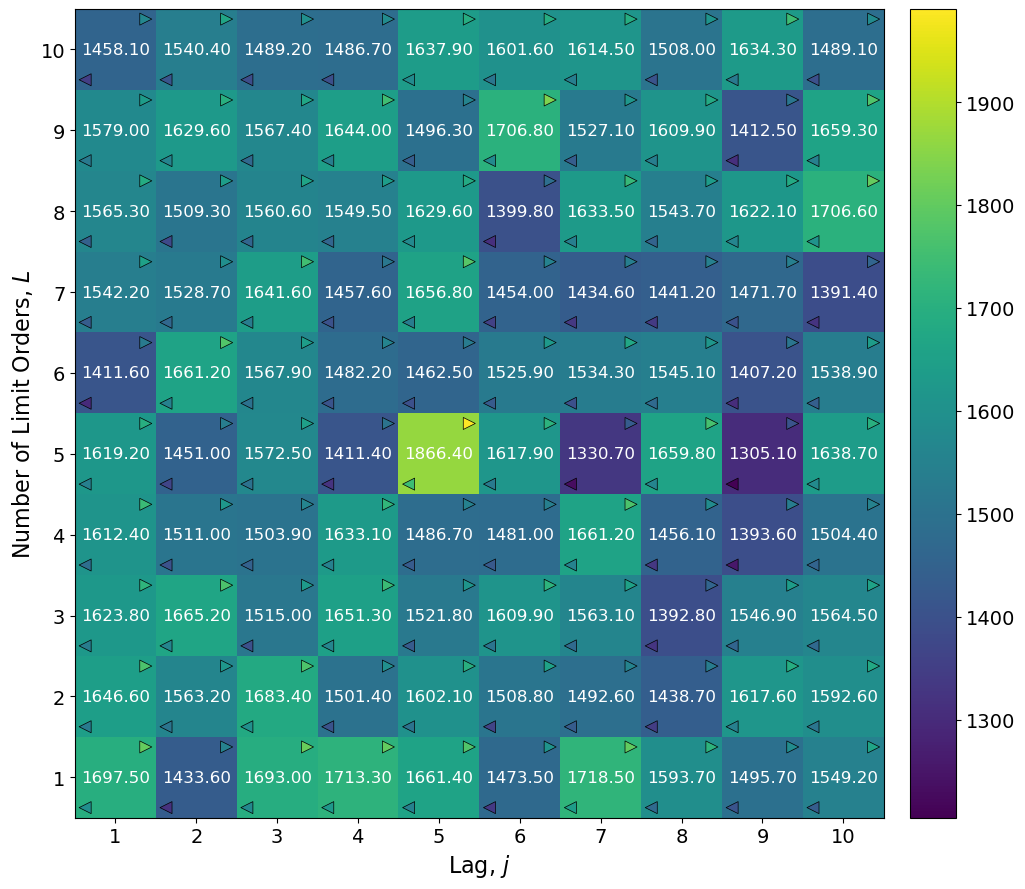

In [302]:
# -------------------------------------------------------------------------
# 2) Plot
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 9))

# -- 2.1 IMSHOW for the mean (est) as the main "square" color in each cell --
#     BUT its color range is from [vmin, vmax], so that the corners (± error)
#     can share the same color scale.
# We do est[::-1,:] if we want the top row to be the highest index (like a matrix).
img = ax.imshow(
    est[::-1, :],
    extent=(x_labels.min() - 0.5, x_labels.max() + 0.5,
            y_labels.min() - 0.5, y_labels.max() + 0.5),
    aspect='equal',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)

# -- 2.2 Plot the corner markers for minus/plus (colored by est_pm_se) --
for k in range(2):
    # c=est_pm_se[:, k] means:
    #   k=0 => 'minus' corner => est - sigma
    #   k=1 => 'plus'  corner => est + sigma
    sc = ax.scatter(
        se_X[:, k],
        se_Y[:, k],
        c=est_pm_se[:, k],
        cmap='viridis',
        vmin=vmin,
        vmax=vmax,
        marker=se_marker[k],
        lw=0.5,
        edgecolor="black",
        s=75,
        zorder=3
    )

cmap = img.cmap
norm = img.norm
# -- 2.3 Annotate each cell with the *mean* value --
for (x_c, y_c, val) in zip(X_flat, Y_flat, est_1d):
    # If the x,y labels match (5,5), make the text black; otherwise keep it white (or whatever you want).
    if x_c == 5 and y_c == 5:
        text_color = "white"
    else:
        text_color = "white"
    
    ax.annotate(
        f"{val:.2f}",
        xy=(x_c, y_c),
        va="center", ha="center",
        color=text_color,
        fontsize = 12,
    )


# -- 2.4 Single colorbar for both squares (mean) & corners (± error).
#    Because 'img' is the first mappable object, we'll create the colorbar from it.
cbar = fig.colorbar(
    img, 
    ax=ax, 
    fraction=0.05, 
    aspect=17.5,
    pad=0.02  # smaller pad => colorbar closer to the plot
)


# -- 2.5 Ticks, labels, layout --
ax.set_xticks(x_labels)
ax.set_yticks(y_labels)
ax.set_xlabel("Lookback")
ax.set_ylabel("Levels")
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels
plt.xlabel("Lag, $j$ ", fontsize=16)
plt.ylabel("Number of Limit Orders, $L$", fontsize=16)

fig.tight_layout()
plt.show()

----